# CS579: Lecture 19  

**Recommendation Systems**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

**Assignment 3 notes.**

In [11]:
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [3]:
import sklearn
sklearn.__version__

'0.16.1'

In [4]:
def my_toker(s):
    return s.split()
    
vec = CountVectorizer(binary=True)
X = vec.fit_transform(['hi there.', 'how a are you you ??'])
print X

  (0, 1)	1
  (0, 3)	1
  (1, 2)	1
  (1, 0)	1
  (1, 4)	1


In [5]:
vec.get_feature_names()

[u'are', u'hi', u'how', u'there', u'you']

In [6]:
vec.fit_transform(['zebra']).todense()
vec.get_feature_names()

[u'zebra']

## Recommendation Systems, continued.

Let's try out some of the ideas from last lecture on the [MovieLens](http://grouplens.org/datasets/movielens/) dataset.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Download the data.
import urllib

urllib.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k/u.data", "u.data")

('u.data', <httplib.HTTPMessage instance at 0x10b03f050>)

In [15]:
# Print first 10 lines:
!head u.data
# schema is: user id | item id | rating | timestamp

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [16]:
!wc -l u.data

  100000 u.data


In [17]:
# Build the giant matrix of user x rating
from scipy.sparse import lil_matrix, csr_matrix

# Recall that lil_matrix is more efficient upon creation, but csr_matrix is more efficient to do dot products.

# We need the number of users/movies in the data.
n_users = 943
n_movies = 1682

X = lil_matrix((n_users, n_movies))

for line in open('u.data', 'rt'):
    cols = [int(c) for c in line.split()]
    X[cols[0]-1, cols[1]-1] = cols[2]  # User IDs start at 1.

In [18]:
X = X.tocsr()
print 'Matrix shape=', X.shape

Matrix shape= (943, 1682)


In [19]:
print 'User 0s ratings:\n', X[0]

User 0s ratings:
  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 19)	4.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  :	:
  (0, 247)	4.0
  (0, 248)	4.0
  (0, 249)	4.0
  (0, 250)	4.0
  (0, 251)	2.0
  (0, 252)	5.0
  (0, 253)	1.0
  (0, 254)	2.0
  (0, 255)	4.0
  (0, 256)	4.0
  (0, 257)	5.0
  (0, 258)	1.0
  (0, 259)	1.0
  (0, 260)	1.0
  (0, 261)	3.0
  (0, 262)	1.0
  (0, 263)	2.0
  (0, 264)	4.0
  (0, 265)	1.0
  (0, 266)	4.0
  (0, 267)	5.0
  (0, 268)	5.0
  (0, 269)	5.0
  (0, 270)	2.0
  (0, 271)	3.0


In [20]:
len(X[0].nonzero()[1])

272

In [21]:
# How many ratings do we have in total?
print '%d total ratings' % len(X.data)

100000 total ratings


In [22]:
# How sparse is this? E.g., how many zeros are there?
print '%f of ratings are empty' % (1. - (1. * len(X.data) / (X.shape[0] * X.shape[1])))

0.936953 of ratings are empty


In [23]:
# How many ratings do we have per person?
# Let's make a binary matrix 
X_binary = X.copy()
X_binary.data = X_binary.data / X_binary.data
print X_binary[1]

  (0, 0)	1.0
  (0, 9)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 18)	1.0
  (0, 24)	1.0
  (0, 49)	1.0
  (0, 99)	1.0
  (0, 110)	1.0
  (0, 126)	1.0
  (0, 236)	1.0
  (0, 241)	1.0
  (0, 250)	1.0
  (0, 254)	1.0
  (0, 256)	1.0
  (0, 257)	1.0
  (0, 268)	1.0
  (0, 271)	1.0
  (0, 272)	1.0
  (0, 273)	1.0
  (0, 274)	1.0
  (0, 275)	1.0
  (0, 276)	1.0
  (0, 277)	1.0
  (0, 278)	1.0
  :	:
  (0, 291)	1.0
  (0, 292)	1.0
  (0, 293)	1.0
  (0, 294)	1.0
  (0, 295)	1.0
  (0, 296)	1.0
  (0, 297)	1.0
  (0, 298)	1.0
  (0, 299)	1.0
  (0, 300)	1.0
  (0, 301)	1.0
  (0, 302)	1.0
  (0, 303)	1.0
  (0, 304)	1.0
  (0, 305)	1.0
  (0, 306)	1.0
  (0, 307)	1.0
  (0, 308)	1.0
  (0, 309)	1.0
  (0, 310)	1.0
  (0, 311)	1.0
  (0, 312)	1.0
  (0, 313)	1.0
  (0, 314)	1.0
  (0, 315)	1.0


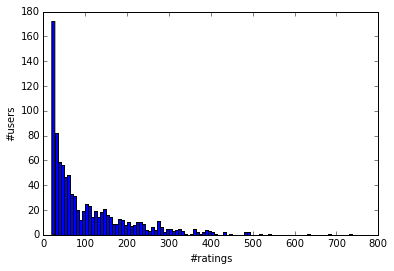

most common reviews per user [(20.0, 32), (21.0, 24), (22.0, 23), (23.0, 21), (24.0, 21), (26.0, 19), (25.0, 16), (27.0, 16), (33.0, 16), (28.0, 15)]


In [24]:
# Now we can count the number of ratings per person by summing by row.
ratings_per_user = X_binary.sum(axis=1).transpose().tolist()[0]

# print ratings_per_user.shape
# print ratings_per_user
plt.figure()
plt.hist(ratings_per_user, bins=100)
plt.xlabel('#ratings')
plt.ylabel('#users')
plt.show()

from collections import Counter
print 'most common reviews per user', Counter(ratings_per_user).most_common(10)

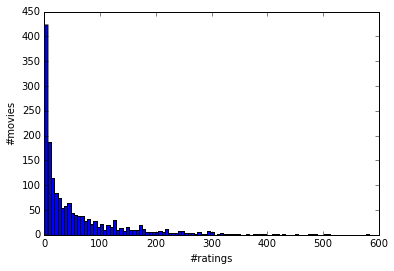

most common reviews per movie [(1.0, 141), (2.0, 68), (4.0, 64), (3.0, 60), (5.0, 51), (7.0, 44), (6.0, 39), (9.0, 33), (10.0, 33), (8.0, 30)]


In [25]:
# Next let's plot the number of ratings per movie
ratings_per_movie = X_binary.sum(axis=0).tolist()[0]

# print ratings_per_movie

plt.figure()
plt.hist(ratings_per_movie, bins=100)
plt.xlabel('#ratings')
plt.ylabel('#movies')
plt.show()

from collections import Counter
print 'most common reviews per movie', Counter(ratings_per_movie).most_common(10)

In [26]:
# For debugging, we'll need the mapping from movie id -> movie name.
urllib.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k/u.item", "u.item")

('u.item', <httplib.HTTPMessage instance at 0x10b056ea8>)

In [27]:
!head u.item
# name, data, url, genre

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

In [28]:
# Read u.item into a dict from movie id -> title.
id2movie = dict()
for line in open('u.item', 'rt'):
    parts = line.split('|')
    id2movie[int(parts[0]) - 1] = parts[1]
print id2movie.items()[0]

(0, 'Toy Story (1995)')


In [29]:
len(id2movie)

1682

In [48]:
def print_user_ratings(row, id2movie, subset=set()):
    indices = row.nonzero()[1]
    if len(subset) > 0:
        indices = set(indices) & set(subset)
    # sort in descending order of rating
    for coli in sorted(indices, key=lambda x: -row[0, x]):
        print coli, id2movie[coli], row[0, coli]
        
print_user_ratings(X[0], id2movie)

0 Toy Story (1995) 5.0
5 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) 5.0
8 Dead Man Walking (1995) 5.0
11 Usual Suspects, The (1995) 5.0
12 Mighty Aphrodite (1995) 5.0
13 Postino, Il (1994) 5.0
14 Mr. Holland's Opus (1995) 5.0
15 French Twist (Gazon maudit) (1995) 5.0
18 Antonia's Line (1995) 5.0
31 Crumb (1994) 5.0
41 Clerks (1994) 5.0
43 Dolores Claiborne (1994) 5.0
44 Eat Drink Man Woman (1994) 5.0
47 Hoop Dreams (1994) 5.0
49 Star Wars (1977) 5.0
54 Professional, The (1994) 5.0
56 Priest (1994) 5.0
58 Three Colors: Red (1994) 5.0
59 Three Colors: Blue (1993) 5.0
63 Shawshank Redemption, The (1994) 5.0
80 Hudsucker Proxy, The (1994) 5.0
81 Jurassic Park (1993) 5.0
85 Remains of the Day, The (1993) 5.0
86 Searching for Bobby Fischer (1993) 5.0
88 Blade Runner (1982) 5.0
90 Nightmare Before Christmas, The (1993) 5.0
92 Welcome to the Dollhouse (1995) 5.0
95 Terminator 2: Judgment Day (1991) 5.0
99 Fargo (1996) 5.0
107 Kids in the Hall: Brain Candy (1996) 5.0
108 Mystery Scien

In [31]:
# What is the highest ranked movie?
import numpy as np
avg_movie_rating = (X.sum(axis=0) / X_binary.sum(axis=0)).A1  # total rating / number of ratings per movie

best_movie_idx = np.argmax(avg_movie_rating)
print 'best movie is %s with rating %f' % (id2movie[best_movie_idx],
                                           avg_movie_rating[best_movie_idx])
print 'ratings:', X[:, best_movie_idx]
print sorted(avg_movie_rating, reverse=True)[:11]

best movie is Great Day in Harlem, A (1994) with rating 5.000000
ratings:   (12, 0)	5.0
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.625]


In [32]:
n_ratings = X_binary.sum(axis=0).A1

for idx in np.argsort(avg_movie_rating)[::-1][:20]:
    print idx, n_ratings[idx], id2movie[idx]


1292 3.0 Star Kid (1997)
1466 2.0 Saint of Fort Washington, The (1993)
1652 1.0 Entertaining Angels: The Dorothy Day Story (1996)
813 1.0 Great Day in Harlem, A (1994)
1121 1.0 They Made Me a Criminal (1939)
1598 1.0 Someone Else's America (1995)
1200 1.0 Marlene Dietrich: Shadow and Light (1996) 
1188 3.0 Prefontaine (1997)
1499 2.0 Santa with Muscles (1996)
1535 1.0 Aiqing wansui (1994)
1448 8.0 Pather Panchali (1955)
1641 2.0 Some Mother's Son (1996)
118 4.0 Maya Lin: A Strong Clear Vision (1994)
1397 2.0 Anna (1996)
1593 2.0 Everest (1998)
407 112.0 Close Shave, A (1995)
317 298.0 Schindler's List (1993)
168 118.0 Wrong Trousers, The (1993)
482 243.0 Casablanca (1942)
113 67.0 Wallace & Gromit: The Best of Aardman Animation (1996)


In [33]:
mylist = [4,5,5,6,1]
print set(mylist)

mylist2 = [4,5,6,10]
print set(mylist2)

print set(mylist) & set(mylist2)

set([1, 4, 5, 6])
set([10, 4, 5, 6])
set([4, 5, 6])


In [34]:
# Let's find the most similar users to user 3.
from scipy.stats import pearsonr

def movies_in_common(Xi, Xj):
    """
    E.g., if Xi has rated movies [10, 20, 30]
    and Xj has rated movies [10, 20, 50]
    return [10, 20]
    """
    return list(set(Xi.nonzero()[1]) & set(Xj.nonzero()[1]))

def find_similar_by_correlation(user, X, n=10):
    correlations = []
    for row in X:
        in_common = movies_in_common(user, row)
        if len(in_common) > 0:
            correlations.append(pearsonr(user[0, in_common].todense().A1,
                                         row[0, in_common].todense().A1)[0])
        else:
            correlations.append(-1)
    correlations = np.nan_to_num(correlations)
    topi = np.argsort(correlations)[::-1][:n]
    return zip(topi, np.array(correlations)[topi])
        
most_similar_users = find_similar_by_correlation(X[0], X, 40)
for idx, corr in most_similar_users:
    print corr, idx

1.0 0
1.0 38
1.0 530
1.0 510
1.0 350
1.0 809
1.0 810
1.0 811
1.0 272
1.0 865
1.0 165
0.918558653544 519
0.916534213783 106
0.904534033733 686
0.891042111214 33
0.882298803383 104
0.870388279778 739
0.866025403784 484
0.866025403784 399
0.866025403784 872
0.862581949178 509
0.852802865422 363
0.84965467929 802
0.845488903031 790
0.843661487732 571
0.838741697276 690
0.816496580928 110
0.814091578411 60
0.810643483378 753
0.794948188396 701
0.777777777778 655
0.777777777778 239
0.774596669241 627
0.771743633141 133
0.766032346285 735
0.752346389217 549
0.752325586977 265
0.75 919
0.75 281
0.734770467867 754


/Users/awculott/.local/lib/python2.7/site-packages/scipy/stats/stats.py:2542: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [57]:
# What do user 38's ratings look like?
in_common = movies_in_common(X[0], X[38])
print_user_ratings(X[38], id2movie, in_common)
print
print_user_ratings(X[0], id2movie, in_common)

257 Contact (1997) 4.0
268 Full Monty, The (1997) 4.0
269 Gattaca (1997) 4.0
271 Good Will Hunting (1997) 2.0

257 Contact (1997) 5.0
268 Full Monty, The (1997) 5.0
269 Gattaca (1997) 5.0
271 Good Will Hunting (1997) 3.0


In [58]:
# What if we don't ignore 0's? 
def find_similar_by_correlation_zeros(user, X, n=10):
    correlations = []
    for row in X:
        correlations.append(pearsonr(user.todense().A1,
                                     row.todense().A1)[0])
    correlations = np.nan_to_num(correlations)
    topi = np.argsort(correlations)[::-1][:n]
    return zip(topi, np.array(correlations)[topi])
        
most_similar_users = find_similar_by_correlation_zeros(X[0], X, 10)
for idx, corr in most_similar_users:
    print corr, idx
    
# What do user 915's ratings look like?
in_common = movies_in_common(X[0], X[38])
print_user_ratings(X[38], id2movie)
print('%d of %d in common' % (len(in_common), len(X[0].data)))

1.0 0
0.487949133033 915
0.471104840007 737
0.465282748572 863
0.457111312198 456
0.457104969265 267
0.454805111853 822
0.445429698702 91
0.44535899324 513
0.444814676191 434
287 Scream (1996) 5.0
301 L.A. Confidential (1997) 5.0
351 Spice World (1997) 5.0
747 Saint, The (1997) 5.0
936 Thousand Acres, A (1997) 5.0
257 Contact (1997) 4.0
268 Full Monty, The (1997) 4.0
269 Gattaca (1997) 4.0
293 Liar Liar (1997) 4.0
312 Titanic (1997) 4.0
314 Apt Pupil (1998) 4.0
318 Everyone Says I Love You (1996) 4.0
332 Game, The (1997) 4.0
346 Wag the Dog (1997) 4.0
299 Air Force One (1997) 3.0
300 In & Out (1997) 3.0
305 Mrs. Brown (Her Majesty, Mrs. Brown) (1997) 3.0
338 Mad City (1997) 3.0
344 Deconstructing Harry (1997) 3.0
899 Kundun (1997) 3.0
271 Good Will Hunting (1997) 2.0
306 Devil's Advocate, The (1997) 2.0
4 of 272 in common


In [37]:
# Find the most similar item to Star Wars (id 513)
def find_similar_movie_by_correlation(movie, X, n=10):
    movie = movie.transpose().toarray()[0]
    correlations = []
    for coli in range(X.shape[1]):
        col = X[:,coli].transpose().toarray()[0]
        correlations.append(pearsonr(movie, col)[0])
    topi = np.argsort(correlations)[::-1][:n]
    return zip(topi, np.array(correlations)[topi])

most_similar_corr = find_similar_movie_by_correlation(X[:,49], X, 10)
for idx, corr in most_similar_corr:
    print corr, idx, id2movie[idx]

1.0 49 Star Wars (1977)
0.748753224156 180 Return of the Jedi (1983)
0.554549408915 171 Empire Strikes Back, The (1980)
0.541920164969 173 Raiders of the Lost Ark (1981)
0.468689970268 209 Indiana Jones and the Last Crusade (1989)
0.457677185391 0 Toy Story (1995)
0.438933019823 194 Terminator, The (1984)
0.420657911412 203 Back to the Future (1985)
0.413546578258 182 Alien (1979)
0.412604182566 172 Princess Bride, The (1987)


In [38]:
# How does this compare with Jaccard?
def find_similar_movie_by_jaccard(movie, X, n=10):
    movie = set(movie.nonzero()[0])
    jaccards = []
    for coli in range(X.shape[1]):
        col = set(X[:,coli].nonzero()[0])
        jaccards.append(1. * len(col & movie) / (len(col | movie)))
    topi = np.argsort(jaccards)[::-1][:n]
    return zip(topi, np.array(jaccards)[topi])

most_similar_jaccard = find_similar_movie_by_jaccard(X[:,49], X, 10)
for idx, corr in most_similar_jaccard:
    print corr, idx, id2movie[idx]


1.0 49 Star Wars (1977)
0.786885245902 180 Return of the Jedi (1983)
0.609951845907 173 Raiders of the Lost Ark (1981)
0.582568807339 0 Toy Story (1995)
0.570247933884 171 Empire Strikes Back, The (1980)
0.565279770445 99 Fargo (1996)
0.558685446009 126 Godfather, The (1972)
0.556923076923 120 Independence Day (ID4) (1996)
0.525078369906 97 Silence of the Lambs, The (1991)
0.510046367852 55 Pulp Fiction (1994)


Jaccard may tend to favor more popular movies.

I leave it as an exercise for the reader to figure out why Toy Story is so similar to Star Wars.